In [1]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from textblob import TextBlob

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import make_pipeline

import pandas as pd
import numpy as np
import re  
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Angela\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Angela\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import pandas as pd
decleor = pd.read_csv("tweets_decleor.csv")
decleor = decleor.drop(['Unnamed: 0', 'Date', 'User'], axis=1)

## Data Cleaning

In [11]:
decleor.head()

,Tweet
0,Decleor Cleansing &amp; Hydrating Ritual 3 Pie...
1,Decleor Hydra Floral Anti-Pollution Hydrating ...
2,Decleor Cleansing &amp; Hydrating Ritual 3 Pie...
3,Decleor Aroma Cleanse Eye Make-Up Remover Gel ...
4,Decleor Cleansing &amp; Hydrating Ritual 3 Pie...


### Remove punctuation, special characters and lower casing

In [12]:
# 1 - Text cleaning
def clean_up(s):
    clean = re.sub(r'http\S+', '', s)
    return re.sub('[^A-Za-z ]+', ' ', clean).lower().strip()

def clean_up2(s):
    clean2 = re.sub(r'\W*\b\w{1,3}\b', '', s)
    return re.sub('[^A-Za-z ]+', ' ', clean2).lower().strip()

In [13]:
# In order to avoid errors, change type to string
decleor['Tweet'] = decleor['Tweet'].apply(str)  # change to string for avoiding errors

In [14]:
decleor['Tweet_Processed'] = decleor['Tweet'].apply(clean_up).apply(clean_up2)
decleor

,Tweet,Tweet_Processed
0,Decleor Cleansing &amp; Hydrating Ritual 3 Pie...,decleor cleansing hydrating ritual piece mk...
1,Decleor Hydra Floral Anti-Pollution Hydrating ...,decleor hydra floral anti pollution hydrating ...
2,Decleor Cleansing &amp; Hydrating Ritual 3 Pie...,decleor cleansing hydrating ritual piece
3,Decleor Aroma Cleanse Eye Make-Up Remover Gel ...,decleor aroma cleanse make remover unisex ...
4,Decleor Cleansing &amp; Hydrating Ritual 3 Pie...,decleor cleansing hydrating ritual piece yyxu
...,...,...
1727,[Ad - Affiliate Link] For all of you needing y...,affiliate link needing your decleoruk there d...
1728,Don’t let the onset of autumn dull your glow! ...,onset autumn dull your glow check this fabulo...
1729,#Dagaanbieding https://t.co/BSEQnJcIlR #verzor...,dagaanbieding verzorging decleor aromessence...
1730,@CollagemW @TKMaxx_UK Lots of Decleor and a Qu...,collagemw tkmaxx lots decleor quinn witch haz...


### Tokenize words and further clean-up text

In [15]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = decleor.Tweet_Processed.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['decleor', 'cleansing', 'hydrating', 'ritual', 'piece', 'mkzoeqw']


### Phrase Modeling: Bigram and Trigram Models

In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

### Remove Stopwords, Make Bigrams and Lemmatize

In [17]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['SA', 'link', '$', 'ohmybeautybank'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Angela\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
#pip install spacy

In [19]:
!python -m spacy download en_core_web_sm
import spacy

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# print(data_lemmatized[:1][0][:30])

     --------------------------------------- 12.8/12.8 MB 43.5 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


### Data Transformation: Corpus and Dictionary

In [20]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1)]


### Base Model

In [21]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

### View the topics in LDA model

The above LDA model is built with 10 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics()

In [22]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.081*"facial" + 0.037*"treatment" + 0.032*"massage" + 0.027*"min" + '
  '0.021*"minute" + 0.021*"relax" + 0.018*"decleor" + 0.016*"offer" + '
  '0.015*"month" + 0.014*"person"'),
 (1,
  '0.025*"body" + 0.017*"join" + 0.016*"sell" + 0.015*"anti_agee" + '
  '0.014*"last" + 0.013*"decleor" + 0.013*"night" + 0.013*"great" + '
  '0.013*"oil" + 0.012*"value"'),
 (2,
  '0.023*"gift" + 0.019*"happy" + 0.017*"set" + 0.017*"decl" + 0.015*"product" '
  '+ 0.014*"weekend" + 0.014*"neroli" + 0.014*"essential" + 0.013*"thing" + '
  '0.012*"full"'),
 (3,
  '0.091*"cream" + 0.051*"skin" + 0.032*"serum" + 0.030*"aromessence" + '
  '0.028*"hydrate" + 0.018*"decl" + 0.015*"face" + 0.014*"product" + '
  '0.013*"mask" + 0.013*"use"'),
 (4,
  '0.064*"skin" + 0.027*"skincare" + 0.021*"decl" + 0.021*"night" + '
  '0.017*"glow" + 0.017*"love" + 0.016*"essential_oil" + 0.014*"essentialoil" '
  '+ 0.011*"green_mandarin" + 0.010*"mask"'),
 (5,
  '0.052*"qvcuk" + 0.043*"fionaskinexpert" + 0.024*"go" + 0.0

### Compute Model Perplexity and Coherence Score

In [23]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3755480434805639


### Hyperparameter Tuning

First, let's differentiate between model hyperparameters and model parameters :

- Model hyperparameters can be thought of as settings for a machine learning algorithm that are tuned by the data scientist before training. Examples would be the number of trees in the random forest, or in our case, number of topics K

- Model parameters can be thought of as what the model learns during training, such as the weights for each word in a given topic.

Now that we have the baseline coherence score for the default LDA model, let's perform a series of sensitivity tests to help determine the following model hyperparameters:

- Number of Topics (K),

- Dirichlet hyperparameter alpha: Document-Topic Density,

- Dirichlet hyperparameter beta: Word-Topic Density,

We'll perform these tests in sequence, one parameter at a time by keeping others constant and run them over the two difference validation corpus sets. We'll use C_v as our choice of metric for performance comparison

In [16]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_decleor.csv', index=False)
    pbar.close()

In [24]:
result = pd.read_csv("lda_tuning_results_decleor.csv")
result

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.250020
1,75% Corpus,2,0.01,0.31,0.279861
2,75% Corpus,2,0.01,0.61,0.255707
3,75% Corpus,2,0.01,0.9099999999999999,0.274573
4,75% Corpus,2,0.01,symmetric,0.258630
...,...,...,...,...,...
535,100% Corpus,10,asymmetric,0.01,0.378775
536,100% Corpus,10,asymmetric,0.31,0.353344
537,100% Corpus,10,asymmetric,0.61,0.415506
538,100% Corpus,10,asymmetric,0.9099999999999999,0.367296


In [25]:
#calculate mean of points grouped by topics
topics = result.groupby('Topics')['Coherence'].mean()
topics

Topics
2     0.280899
3     0.298459
4     0.313838
5     0.333120
6     0.341556
7     0.346620
8     0.363334
9     0.379912
10    0.366630
Name: Coherence, dtype: float64

In [26]:
# Generated by OPEN AI 
import pandas as pd

data = {'Topics': [2, 3, 4, 5, 6, 7, 8, 9, 10],
        'Coherence': [0.280899, 0.298459, 0.313838, 0.333120, 0.341556, 0.346620, 0.363334, 0.379912, 0.366630]}

df = pd.DataFrame(data)

print(df)

   Topics  Coherence
0       2   0.280899
1       3   0.298459
2       4   0.313838
3       5   0.333120
4       6   0.341556
5       7   0.346620
6       8   0.363334
7       9   0.379912
8      10   0.366630


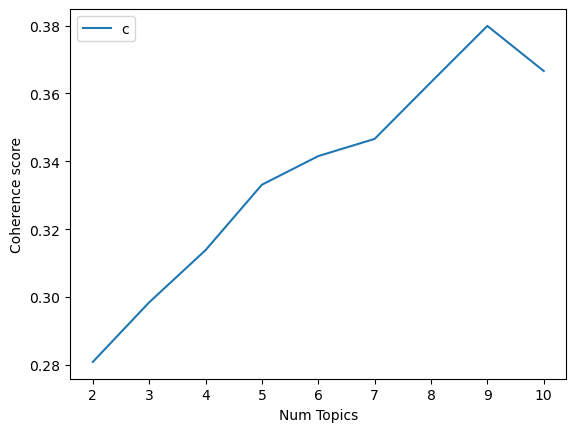

In [27]:
# Show graph -- fix it!
limit=40; start=2; step=6;
x = df['Topics']
y = df['Coherence']
plt.plot(x, y)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Final Model

In [28]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=9, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto')

In [29]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds = "mmds", R=30)
vis

C:\Users\Angela\ANACONDA\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
C:\Users\Angela\ANACONDA\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.318706  0.266600       1        1  28.228660
8      0.001766 -0.410629       2        1  14.483946
0     -0.396157 -0.103543       3        1  12.064819
7     -0.253763  0.286314       4        1  10.808061
2      0.207996 -0.214258       5        1   8.667487
5      0.309715 -0.015634       6        1   8.464370
1      0.021746  0.281829       7        1   6.771246
6     -0.117420 -0.148003       8        1   6.317467
3     -0.092589  0.057325       9        1   4.193942, topic_info=                  Term        Freq       Total Category  logprob  loglift
23              beauty  288.000000  288.000000  Default  30.0000  30.0000
81                skin  356.000000  356.000000  Default  29.0000  29.0000
27              facial  151.000000  151.000000  Default  28.0000  28.0000
30             product  255.000000  255.000000  Default  27.0000  27.0000
71               offer   92.000000   92.000000  Default  26.0000  26.0000
..                 ...         ...         ...      ...      ...      ...
478            vitamin    3.614762    4.325405   Topic9  -5.1710   2.9920
823  reduce_appearance    3.466966    4.177471   Topic9  -5.2127   2.9851
5                cream   47.584588  119.572943   Topic9  -2.5935   2.2501
62                mask   15.529010   53.640358   Topic9  -3.7133   1.9319
132        aromessence    8.855488   51.916688   Topic9  -4.2750   1.4029

[325 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2868      7  0.943843     acrylic
809       6  0.943388   advantage
547       2  0.944090   affiliate
2844      9  0.828123  afterwards
268       1  0.988433         age
...     ...       ...         ...
920       1  0.973859        work
130       2  0.983019       worth
185       9  0.974263     wrinkle
840       9  0.865081       write
103       1  0.990641        year

[302 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 9, 1, 8, 3, 6, 2, 7, 4])

In [30]:
pyLDAvis.save_html(vis, 'lda_visualization_decleor.html')

# Download the HTML file
#from google.colab import files
#files.download('lda_visualization.html')

In [31]:
# Recommendations at the end of the presentation
# esta informe se ha generado con un pipeline flexible...

In [32]:
pyLDAvis.save_html(vis, 'lda_visualization_decleor.html')